# AOAI - Car Reviews Assignment

## Modules import

In [1]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
sns.set_theme()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mcarciani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mcarciani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mcarciani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mcarciani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Import the data

In [2]:
df = pd.read_csv('car-reviews.csv')

# Data visual analysis
Let's start by performing some visual analysis on the dataset: Specifically, I will plot the review length distribution.  
This may help us identify possible malformed data. Additionally we can visually analyze the data to see if the review length may be an additional estimator for its sentiment.

Number of characters of the shortest review = 488
Number of characters of the longest review = 21172


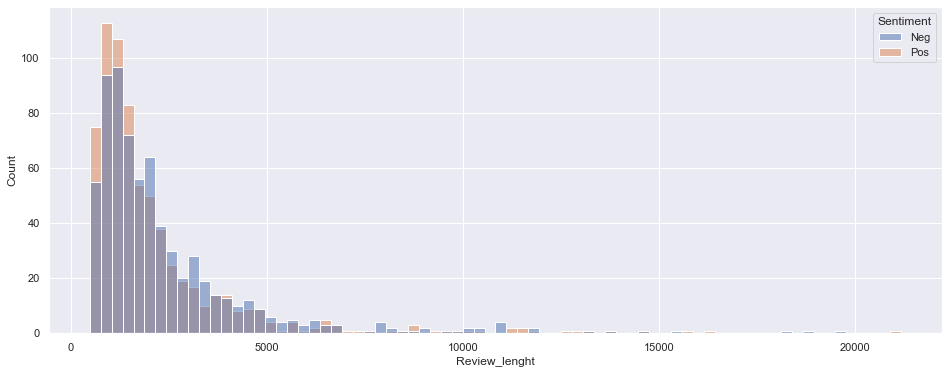

In [3]:
s = df['Review'].str.len()
df_exploration = df.copy()
df_exploration['Review_lenght'] = s
print(f'Number of characters of the shortest review = {min(s)}')
print(f'Number of characters of the longest review = {max(s)}')
plt.figure(figsize=(16, 6))
sns.histplot(df_exploration,x='Review_lenght',hue="Sentiment");

 Let us plot the distribution of word count per sentiment.

Number of words of the shortest review = 110
Number of words of the longest review = 4254


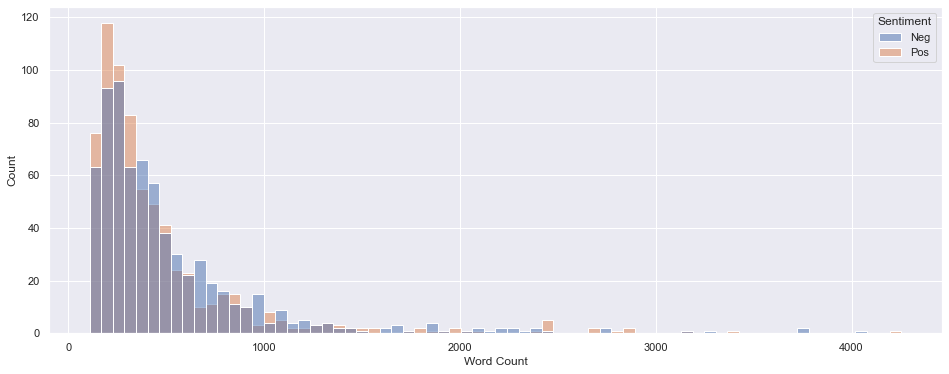

In [4]:
df_exploration['Word Count'] = df['Review'].str.split(" ").str.len()
df_exploration['Word Count'].min()
df_exploration['Word Count'].max()
print(f"Number of words of the shortest review = {df_exploration['Word Count'].min()}")
print(f"Number of words of the longest review = {df_exploration['Word Count'].max()}")
plt.figure(figsize=(16, 6))
sns.histplot(df_exploration,x='Word Count',hue="Sentiment");


From both distributions it is possible to infer that positive reviews tend to be shorter and have fewer words.  Though, there is no clear cut and it is unlikely word count or number of characters may play a role in determining the review’s sentiment.

In [5]:
s_pos =  df[df['Sentiment']=='Pos']['Review'].str.len()
print(f'Number of characters of the shortest positive review = {min(s_pos)}')
print(f'Number of characters of the longest positive review = {max(s_pos)}')

Number of characters of the shortest positive review = 488
Number of characters of the longest positive review = 21172


In [6]:
s_neg = df[df['Sentiment']=='Neg']['Review'].str.len()
print(f'Number of characters of the shortest negative review = {min(s_neg)}')
print(f'Number of characters of the longest negative review = {max(s_neg)}')

Number of characters of the shortest negative review = 507
Number of characters of the longest negative review = 19600


# Data pre-processing 

Before training the classifier it is good practice and sometime strictly necessary to do preprocessing; More specifically
- Conversion to lowercase characters: to make the input review case independent
- Word tokenization: This is a necessary steps to use a bag of word approach for classification
- Punctuation removal: Punctuation do not contribute to the level of information about the sentiment of the text. it's good practice to remove it.
- Stop words removal: Stop words are those words which may be very frequent but carry very little to no information at all about the sentiment of the text
- Stemming: it's good practice to transform multiple words having the same stem to the stem word. This improve the classification performance as well as reduces the feature sparsity and dimensionality.

Finally the remaining words are joint together to form the processed review 

The preprocessing steps above are clustered into a processing pipeline by means of  **Sklearn Pipeline**  module

The definition of the single function used for pre-processing can be found below


In [7]:
def lower_case(X):
    return [review.lower() for review in X]

In [8]:
def tokenize(X):
    return [[word for word in word_tokenize(review)]for review in X]

In [9]:
def remove_punct(X):
    punctuation = {".", ",", ";", "?", "!"}
    return [[word for word in review if
                    word not in punctuation] for review in X]
    #return [[word for word in review if
    #                word not in punctuation and word not in stopwords_set and word.isalpha()] for review in X]

In [10]:
def remove_stopwords(X):
    stopwords_set = set(stopwords.words('english'))
    return [[word for word in review if
                    word not in stopwords_set and word.isalpha()] for review in X]

In [11]:
def stem(X):
    ps = PorterStemmer()
    return [[ps.stem(word) for word in review] for review in X]

In [12]:
def stich_tokens(X):
    return [" ".join(review) for review in X]

In [13]:
def sentiment_to_int(Y):
    Y_int = (Y == 'Pos').array.astype(int)
    return Y_int

In [14]:
processing_pipe = Pipeline([('lower_case',FunctionTransformer(lower_case)),
                            ('tokenize',FunctionTransformer(tokenize)),
                            ('remove_punct',FunctionTransformer(remove_punct)),
                            ('remove_stopwords',FunctionTransformer(remove_stopwords)),
                            ('stem',FunctionTransformer(stem)),
                            ('stich',FunctionTransformer(stich_tokens))])

## Demonstrating pre-processing steps
I am now going to demonstrate the pre-processing steps one by one and show their intermediate outputs.

### Make all reviews case insensitive

In [15]:
review_lower = lower_case(df.Review)

In [16]:
print("Original review set:\n")
print(df.Review[0:5])

Original review set:

0     In 1992 we bought a new Taurus and we really ...
1     The last business trip  I drove to San Franci...
2     My husband and I purchased a 1990 Ford F250 a...
3     I feel I have a thorough opinion of this truc...
4     AS a mother of 3  all of whom are still in ca...
Name: Review, dtype: object


In [17]:
print("Case insensitive review set:\n")
print(pd.Series(review_lower[0:5]))

Case insensitive review set:

0     in 1992 we bought a new taurus and we really ...
1     the last business trip  i drove to san franci...
2     my husband and i purchased a 1990 ford f250 a...
3     i feel i have a thorough opinion of this truc...
4     as a mother of 3  all of whom are still in ca...
dtype: object


### Remove punctuation, stop words and any word which contains numbers

In [18]:
X_token = tokenize(review_lower)
X_no_punct = remove_punct(X_token)
X_no_stopwords = remove_stopwords(X_no_punct)

In [19]:
print("\nTokenized reviews with no stop words and punctuation: \n")
pd.DataFrame(X_no_stopwords)[0:20]


Tokenized reviews with no stop words and punctuation: 



,0,1,2,3,4,5,6,7,8,9,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
0,bought,new,taurus,really,loved,decided,try,new,taurus,care,...,None,None,None,None,None,None,None,None,None,None
1,last,business,trip,drove,san,francisco,went,hertz,rentals,got,...,None,None,None,None,None,None,None,None,None,None
2,husband,purchased,ford,nothing,problems,owned,vehicle,approximately,two,years,...,None,None,None,None,None,None,None,None,None,None
3,feel,thorough,opinion,truck,compared,post,evaluations,vehicles,truck,owned,...,None,None,None,None,None,None,None,None,None,None
4,mother,still,carseats,logical,thing,trade,minivan,minivan,one,handful,...,None,None,None,None,None,None,None,None,None,None
5,ford,winstar,car,would,recommend,purchasing,driven,van,several,times,...,None,None,None,None,None,None,None,None,None,None
6,bought,van,rental,since,birth,initially,loved,everything,dreamed,plenty,...,None,None,None,None,None,None,None,None,None,None
7,bought,focus,wagon,cargo,space,great,camping,hardware,store,ride,...,None,None,None,None,None,None,None,None,None,None
8,probably,heard,giant,ford,excursion,sport,utility,vehicle,carries,significant,...,None,None,None,None,None,None,None,None,None,None
9,thought,gmc,chevrolet,suburban,big,wait,till,see,ford,excursion,...,None,None,None,None,None,None,None,None,None,None


### Apply Stemming

In [20]:
X_stem = stem(X_no_stopwords)
print("Tokenized reviews after applying stemming: \n")
pd.DataFrame(X_stem)[0:20]

Tokenized reviews after applying stemming: 



,0,1,2,3,4,5,6,7,8,9,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
0,bought,new,tauru,realli,love,decid,tri,new,tauru,care,...,None,None,None,None,None,None,None,None,None,None
1,last,busi,trip,drove,san,francisco,went,hertz,rental,got,...,None,None,None,None,None,None,None,None,None,None
2,husband,purchas,ford,noth,problem,own,vehicl,approxim,two,year,...,None,None,None,None,None,None,None,None,None,None
3,feel,thorough,opinion,truck,compar,post,evalu,vehicl,truck,own,...,None,None,None,None,None,None,None,None,None,None
4,mother,still,carseat,logic,thing,trade,minivan,minivan,one,hand,...,None,None,None,None,None,None,None,None,None,None
5,ford,winstar,car,would,recommend,purchas,driven,van,sever,time,...,None,None,None,None,None,None,None,None,None,None
6,bought,van,rental,sinc,birth,initi,love,everyth,dream,plenti,...,None,None,None,None,None,None,None,None,None,None
7,bought,focu,wagon,cargo,space,great,camp,hardwar,store,ride,...,None,None,None,None,None,None,None,None,None,None
8,probabl,heard,giant,ford,excurs,sport,util,vehicl,carri,signific,...,None,None,None,None,None,None,None,None,None,None
9,thought,gmc,chevrolet,suburban,big,wait,till,see,ford,excurs,...,None,None,None,None,None,None,None,None,None,None


In [21]:
# Helper function to merge each review dictionary in one global dictionary containing all words used amongst all reviews
def merge_counter(*counter_args):
    counter_args, = counter_args
    c = Counter({})
    for c1 in counter_args:
        c.update(c1)
    return c

In [22]:
# Retriving word frequencies before stemming
X_no_stem_counter = [Counter(review) for review in X_no_stopwords]
all_reviews_no_stem_dict = merge_counter(X_no_stem_counter)
xy_no_stem = [(tag,count) for tag, count in all_reviews_no_stem_dict.most_common(20)]
df_no_stem = pd.DataFrame(xy_no_stem, columns = ['word','occurrences'])
clrs_no_stem = ['red' if w=='drive' else 'yellow' if w=='seat' else 'green' if w=='get' else 'c' for w in df_no_stem.word]

In [23]:
# Retriving word frequencies after stemming
X_stem_counter = [Counter(review) for review in X_stem]
all_reviews_stem_dict = merge_counter(X_stem_counter)
xy_stem = [(tag,count) for tag, count in all_reviews_stem_dict.most_common(20)]
df_stem = pd.DataFrame(xy_stem,columns = ['word','occurrences'])
clrs_stem = ['red' if w=='drive' else 'yellow' if w=='seat' else 'green' if w=='get' else 'c' for w in df_stem.word]

## Plotting Most common words  before and after stemming¶

The Barnhart demonstrates how applying stemming to the corpus increases the stem words frequency. For example words like **get**, **drive** and **seat** (being stem words) have a higher frequency after stemming as displayed by the green, red and yellow bars.

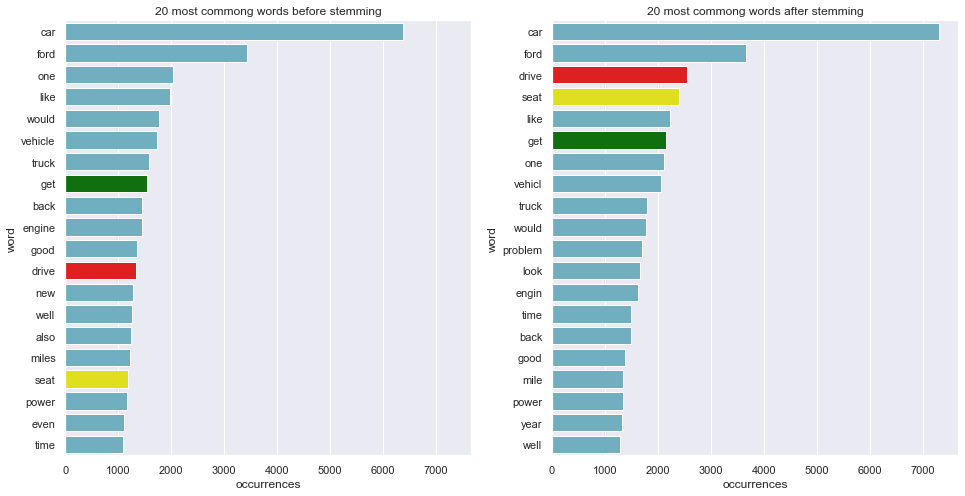

In [24]:
fig, axes = plt.subplots(1, 2,sharex=True, figsize=(16,8))
axes[0].set_title('20 most commong words before stemming');
axes[1].set_title('20 most commong words after stemming');
sns.barplot(ax = axes[0],y='word',x='occurrences',data=df_no_stem, palette=clrs_no_stem);
sns.barplot(ax = axes[1],y='word',x='occurrences',data=df_stem, palette=clrs_stem);

## Demonstrate stemming on words: Drive, Get, Seat
I here demostrate that stemming is correctly applied by counting the occurrences of the word stem and its inflected variants.

In [25]:
K = ['drive',"driving","drives","get","gets","getting","seat","seating",'seats','seated']
l = []
for i in range(2):
    d = {}
    for k in K:
        if i == 0:
            d[k] = all_reviews_no_stem_dict[k]
        else:
            d[k] = all_reviews_stem_dict[k]
    l.append(d)
pd.DataFrame(l)

,drive,driving,drives,get,gets,getting,seat,seating,seats,seated
0,1331,1078,146,1550,259,346,1193,137,1049,11
1,2555,0,0,2155,0,0,2390,0,0,0


## Extract feature vector from reviews

To extract the feature vector from each review I have used the very handy CountVectorizer module by **Sklearn**.
To give a little context, it returns a sparse matrix representation of the input where each row correspond to one review and the number of column is equal to the total number of unique words amongst all reviews. the element Xij is number of occurrences aka term frequency of the word j in the review i.

In [26]:
X_processed = stich_tokens(X_stem)
cv = CountVectorizer(binary=False)
X_train_int = cv.fit_transform(X_processed);
print("Training data input matrix:")
print(X_train_int)

Training data input matrix:
  (0, 919)	2
  (0, 5579)	3
  (0, 8474)	3
  (0, 6749)	1
  (0, 4942)	1
  (0, 2132)	1
  (0, 8880)	1
  (0, 1203)	1
  (0, 8216)	3
  (0, 5582)	1
  (0, 9339)	1
  (0, 349)	1
  (0, 4836)	2
  (0, 1195)	1
  (0, 3765)	1
  (0, 5455)	2
  (0, 5805)	1
  (0, 8574)	1
  (0, 2073)	1
  (0, 2146)	1
  (0, 8437)	1
  (0, 4929)	1
  (0, 7118)	1
  (0, 3112)	1
  (0, 7339)	2
  :	:
  (1381, 1284)	1
  (1381, 7862)	1
  (1381, 9)	1
  (1381, 1511)	1
  (1381, 6866)	2
  (1381, 8251)	1
  (1381, 4589)	1
  (1381, 4063)	1
  (1381, 1302)	1
  (1381, 1816)	1
  (1381, 68)	1
  (1381, 5560)	1
  (1381, 5559)	1
  (1381, 5538)	1
  (1381, 4341)	1
  (1381, 3436)	1
  (1381, 9809)	2
  (1381, 1270)	1
  (1381, 6740)	1
  (1381, 3378)	1
  (1381, 762)	1
  (1381, 6134)	1
  (1381, 626)	1
  (1381, 2177)	1
  (1381, 4312)	1


In [27]:
review_number = [0,1,2]
feature_columns = [919,3112,7212,8216]
for n in feature_columns:
    print(f"column {n} corresponds to the stem word \"{cv.get_feature_names()[n]}\"")
    for nr in review_number:
        print(f"\"{cv.get_feature_names()[n]}\" is present {X_train_int[nr,n]} times in review number {nr}")
    print("\n")

column 919 corresponds to the stem word "bought"
"bought" is present 2 times in review number 0
"bought" is present 0 times in review number 1
"bought" is present 1 times in review number 2


column 3112 corresponds to the stem word "find"
"find" is present 1 times in review number 0
"find" is present 1 times in review number 1
"find" is present 1 times in review number 2


column 7212 corresponds to the stem word "said"
"said" is present 0 times in review number 0
"said" is present 0 times in review number 1
"said" is present 3 times in review number 2


column 8216 corresponds to the stem word "style"
"style" is present 3 times in review number 0
"style" is present 0 times in review number 1
"style" is present 0 times in review number 2




Now that I have demonstrated the preprocessing pipeline and feature extraction step by step, it is time to dive into training/test data splitting and classifier tuning.

## Splitting the data set into Training and Test data

I split the dataset in training and test in an 80%-20% proportion while maintaining a 50-50 balance in the number of positive and negative reviews in both sets.  
**NOTE**: In order to maintain result consistency between runs the random seed is set to 0 when splitting the dataset.

In [28]:
# Separate the negative and positive reviews
df_pos = df[df['Sentiment'] == 'Pos']
df_neg = df[df['Sentiment'] == 'Neg']

# Split both positive and negative set in a 80% 20% fashion
train_pos, test_pos = train_test_split(df_pos,test_size=0.2,random_state=1)
train_neg, test_neg = train_test_split(df_neg,test_size=0.2,random_state=1)

# Create training set and test set
train_data = pd.concat([train_pos,train_neg])
train_data.sample(frac=1, random_state=1)   # shuffle the train data
test_data = pd.concat([test_pos,test_neg])
# No need to shuffle the test data

# Extract reviews and labels for the train data
X_train = train_data.Review 
Y_train = train_data.Sentiment

# Extract reviews and lable for the test data
X_test = test_data.Review
Y_test = test_data.Sentiment

data =  pd.concat([train_data,test_data])
data.sample(frac=1, random_state=1);

## Create a Multinomial Naive Bayes model

In this first part I will be considering only a  Multinomial Naive Bayes classifier which is the standard Naive Bayes classifier for text classification tasks.

In [29]:
# CREATE THE MULTINOMIAL NAIVE BAYES MODEL
MN_NaiveBayes = MultinomialNB()

## Create a feature extraction + classifier pipeline
It is worth mentioning that introducing the feature extraction step in the same pipeline as the classifier training removes any possibility of data leakage not only with respect to the test data but also during cross validation on the training data.

In [30]:
pipe1 = Pipeline([('feature_extraction',CountVectorizer(binary=False)),
                ('clsf',MultinomialNB())])

In [31]:
# Convert Pos to 1 and Neg to 0
Y_train_int = sentiment_to_int(Y_train)

## K-Fold validated grid search
In order to tune the model hyper parameters, I used K-Fold validated Grid Search `GridSearchCV` by sklearn.

In [32]:
# Set the parameters to test during GridSearch
param_grid1 = {
    "clsf__alpha": np.logspace(-1, 1, num=10),
}
gsCV = GridSearchCV(pipe1, param_grid1, scoring= 'accuracy', cv=5, verbose=3, n_jobs=1)

In [33]:
%%time
# Runt the data processing pipiline on the training data
X_train_processed = processing_pipe.fit_transform(X_train)

Wall time: 9.61 s


In [34]:
# Run GridSearchCV
gsCV.fit(X_train_processed, Y_train_int);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] clsf__alpha=0.1 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... clsf__alpha=0.1, score=0.760, total=   0.3s
[CV] clsf__alpha=0.1 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ..................... clsf__alpha=0.1, score=0.751, total=   0.2s
[CV] clsf__alpha=0.1 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ..................... clsf__alpha=0.1, score=0.787, total=   0.3s
[CV] clsf__alpha=0.1 .................................................
[CV] ..................... clsf__alpha=0.1, score=0.733, total=   0.3s
[CV] clsf__alpha=0.1 .................................................
[CV] ..................... clsf__alpha=0.1, score=0.718, total=   0.3s
[CV] clsf__alpha=0.16681005372000587 .................................
[CV] ..... clsf__alpha=0.16681005372000587, score=0.769, total=   0.3s
[CV] clsf__alpha=0.16681005372000587 .................................
[CV] ..... clsf__alpha=0.16681005372000587, score=0.760, total=   0.3s
[CV] clsf__alpha=0.16681005372000587 .................................
[CV] ..... clsf__alpha=0.16681005372000587, score=0.792, total=   0.3s
[CV] clsf__alpha=0.16681005372000587 .................................
[CV] ..... clsf__alpha=0.16681005372000587, score=0.747, total=   0.3s
[CV] clsf__alpha=0.16681005372000587 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.6s finished


## Get the best model

I now retrieve the best performing model along with its score. This will be the baseline reference model whose accuracy I'll try to improve.

In [35]:
# GET THE BEST MODEL
best_param_baseline = gsCV.best_params_
best_score_baseline = gsCV.best_score_
best_model_baseline = gsCV.best_estimator_
print(f'Best Model = {best_model_baseline}\nAlpha ={best_param_baseline}\nAccuracy score = {best_score_baseline}\n')

Best Model = Pipeline(steps=[('feature_extraction', CountVectorizer()),
                ('clsf', MultinomialNB(alpha=0.774263682681127))])
Alpha ={'clsf__alpha': 0.774263682681127}
Accuracy score = 0.772607980255039



We obtained a 5-fold cross-validated accuracy of 77.26%

Average accuracy = 0.8057553956834532
F1 score = 0.8098591549295774
[[109  30]
 [ 24 115]]


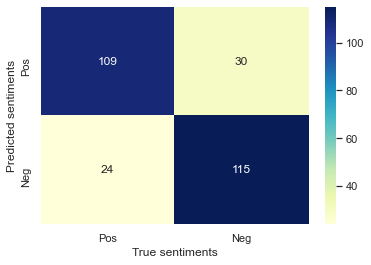

In [36]:
test =  True
if test:
    Y_test_int = sentiment_to_int(Y_test)
    X_test_processed = processing_pipe.transform(X_test)
    Y_test_pred = best_model_baseline.predict(X_test_processed)
    cnf_matrix = confusion_matrix(Y_test_int, Y_test_pred)
    avg_acc = accuracy_score(Y_test_int, Y_test_pred)
    f1 = f1_score(Y_test_int, Y_test_pred)
    print(f"Average accuracy = {avg_acc}")
    print(f"F1 score = {f1}")
    print(cnf_matrix)
    ax = sns.heatmap(cnf_matrix, annot=True, fmt="d",xticklabels=["Pos","Neg"],yticklabels=["Pos","Neg"],cmap="YlGnBu");
    plt.xlabel('True sentiments')
    plt.ylabel('Predicted sentiments')

# Part 2 - improve classifiction perfomances

From here onward I will attempt to improve the classification performances I obtained just above.
I will be carrying out few different experiments, more specifically:

**Experiment 1**
- Binary vs full-word-count feature vector
- tf vs tf-idf

**Experiment 2**
- Fixed window negation handling

**Experiment 3**
- Dependency parser negation handling

**Experiment 4**
- Dense feature vector representation by means of word embedding.

In the first 3 experiments 3 classifiers are compared against each other, more specifically, Multinomial Naive Bayes, Logistic regression and SVC. In the last experiment (Expertiment4) only Logistic Regression and SVC are used as the feature vector might contain negative values which are not supported by Multinomial Naive Bayes  
All models are compared against each other using GridSearchCV by sklearn


## Experiment 1
In part 1, each review feature vector was composed by the term frequency component (tf) of each word in the review. It is important to specify that the length of the feature vector may be much longer than the number of unique words in each review as it contains all unique words amongst all reviews in the training data.
In this experiment I will explore another technique to represent the feature vectors.
By considering term frequency, terms which appear often in the reviews can carry a big weight but low information about the sentiment of the review itself.
To take care of this, it is possible to standardize every column of the feature vector by multiply each value by the inverse of term frequency amongst all reviews. This is called **tf-idf**. This is indeed a form of feature normalization where the most frequent terms are penalized the most effectively scaling every term to a value between 0 and 1.
For both **tf** an  **tf-idf** the **tf** part can either be the term count or the term existence (binary) in the review. 
In the section below I will explore all 4 approaches:
- tf  (count)
- tf  (binary)
- tf-idf (count)
- tf-idf (binary)


I created a pipeline `pipe_exp1` in which the first step is the feature extraction and the second step is the classifier training. 
I am going to use GridSearchCV to test the two type of vectorizers with different values for the `binary` argument. When the binary argument is set to true the resulting feature vector will only contain the information about the existence of words rather than their count.

In [37]:
# Create feature extraction and classifier training pipeline
pipe_exp1 = Pipeline([('vectorizer',None),
                 ('clsf',MultinomialNB())])

In [38]:
# Set the parameters to change during the cross validated grid search
param_grid_exp1 = [{'vectorizer': [CountVectorizer(),TfidfVectorizer()],
                'vectorizer__binary' : [True, False],
               'clsf__alpha': np.logspace(-1, 1, num=10)}]
gsCV_exp1 = GridSearchCV(pipe_exp1, param_grid_exp1, scoring= 'accuracy', cv=5, verbose=3)

In [39]:
# Pre-process the training data: lables and features
Y_train_int = sentiment_to_int(Y_train)
X_train_processed = processing_pipe.transform(X_train)

In [40]:
# Run Cross Validated Grid Search CV
gsCV_exp1.fit(X_train_processed,Y_train_int)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.769, total=   0.3s
[CV] clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.751, total=   0.2s
[CV] clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.796, total=   0.3s
[CV] clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.760, total=   0.2s
[CV] clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.745, total=   0.3s
[CV] clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=False 
[CV]  clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=False, score=0.760, total=   0.2s
[CV] clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=False 
[CV]  clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=False, score=0.751, total=   0.2s
[CV] clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=False 
[CV]  clsf__alpha=0.1, vectorizer=CountVectorizer(), vectorizer__binary=False, score=

[CV]  clsf__alpha=0.2782559402207124, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.787, total=   0.2s
[CV] clsf__alpha=0.2782559402207124, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=0.2782559402207124, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.741, total=   0.2s
[CV] clsf__alpha=0.2782559402207124, vectorizer=CountVectorizer(), vectorizer__binary=False 
[CV]  clsf__alpha=0.2782559402207124, vectorizer=CountVectorizer(), vectorizer__binary=False, score=0.774, total=   0.2s
[CV] clsf__alpha=0.2782559402207124, vectorizer=CountVectorizer(), vectorizer__binary=False 
[CV]  clsf__alpha=0.2782559402207124, vectorizer=CountVectorizer(), vectorizer__binary=False, score=0.756, total=   0.2s
[CV] clsf__alpha=0.2782559402207124, vectorizer=CountVectorizer(), vectorizer__binary=False 
[CV]  clsf__alpha=0.2782559402207124, vectorizer=CountVectorizer(), vectorizer__binary=False, score=0.792, total=   0.2s
[CV] clsf__alpha=0.2782559

[CV]  clsf__alpha=0.774263682681127, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.801, total=   0.2s
[CV] clsf__alpha=0.774263682681127, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=0.774263682681127, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.778, total=   0.3s
[CV] clsf__alpha=0.774263682681127, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=0.774263682681127, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.736, total=   0.4s
[CV] clsf__alpha=0.774263682681127, vectorizer=CountVectorizer(), vectorizer__binary=False 
[CV]  clsf__alpha=0.774263682681127, vectorizer=CountVectorizer(), vectorizer__binary=False, score=0.760, total=   0.3s
[CV] clsf__alpha=0.774263682681127, vectorizer=CountVectorizer(), vectorizer__binary=False 
[CV]  clsf__alpha=0.774263682681127, vectorizer=CountVectorizer(), vectorizer__binary=False, score=0.774, total=   0.3s
[CV] clsf__alpha=0.774263682681127, v

[CV]  clsf__alpha=2.1544346900318834, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.756, total=   0.3s
[CV] clsf__alpha=2.1544346900318834, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=2.1544346900318834, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.810, total=   0.3s
[CV] clsf__alpha=2.1544346900318834, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=2.1544346900318834, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.792, total=   0.3s
[CV] clsf__alpha=2.1544346900318834, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=2.1544346900318834, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.764, total=   0.3s
[CV] clsf__alpha=2.1544346900318834, vectorizer=CountVectorizer(), vectorizer__binary=False 
[CV]  clsf__alpha=2.1544346900318834, vectorizer=CountVectorizer(), vectorizer__binary=False, score=0.756, total=   0.3s
[CV] clsf__alpha=2.15443469003

[CV]  clsf__alpha=5.994842503189409, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.783, total=   0.3s
[CV] clsf__alpha=5.994842503189409, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=5.994842503189409, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.778, total=   0.3s
[CV] clsf__alpha=5.994842503189409, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=5.994842503189409, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.810, total=   0.3s
[CV] clsf__alpha=5.994842503189409, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=5.994842503189409, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.810, total=   0.2s
[CV] clsf__alpha=5.994842503189409, vectorizer=CountVectorizer(), vectorizer__binary=True 
[CV]  clsf__alpha=5.994842503189409, vectorizer=CountVectorizer(), vectorizer__binary=True, score=0.755, total=   0.3s
[CV] clsf__alpha=5.994842503189409, vecto

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   56.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', None),
                                       ('clsf', MultinomialNB())]),
             param_grid=[{'clsf__alpha': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
                          'vectorizer': [CountVectorizer(),
                                         TfidfVectorizer(binary=True)],
                          'vectorizer__binary': [True, False]}],
             scoring='accuracy', verbose=3)

In [41]:
# Get the best performing model
best_param_exp1 = gsCV_exp1.best_params_
best_score_exp1 = gsCV_exp1.best_score_
best_model_exp1 = gsCV_exp1.best_estimator_
print(f'Best Model = {best_model_exp1}\nAlpha ={best_param_exp1}\nAccuracy score = {best_score_exp1}\n')

Best Model = Pipeline(steps=[('vectorizer', TfidfVectorizer(binary=True)),
                ('clsf', MultinomialNB(alpha=0.774263682681127))])
Alpha ={'clsf__alpha': 0.774263682681127, 'vectorizer': TfidfVectorizer(binary=True), 'vectorizer__binary': True}
Accuracy score = 0.7889263677498971



TfidfVectorizer with the property `binary = True` gives the best cross validation performance. In other word, the presence of specific words seems to be more important than their frequencies.  
I am now going to fix these settings for the feature extraction step and perform a GridSearchCV using three different classifiers:
- Multinomial Naive Bayes
- Logistic regression
- SVC


In [42]:
# Creating the feature extraction and classifier pipeline 
pipe_exp1 = Pipeline([('vectorizer',TfidfVectorizer(binary=True)),
                 ('clsf',MultinomialNB())])
# Set the parametes to change during GridSearch
param_grid_exp1 = [{'clsf': [MultinomialNB()],
              'clsf__alpha': np.logspace(-1, 1, num=10)},
              {'clsf': [LogisticRegression()],
              'clsf__C': [0.16, 0.32, 0.64, 1.28, 2.56, 3.84, 5.12,5.76,6.36, 7,7.5,7.8,8,8.2,8.5,9]},
              {'clsf': [SVC()],
              'clsf__C': [0.64, 1.28, 2.56, 3.84, 5.12]}]
gsCV_exp1 = GridSearchCV(pipe_exp1, param_grid_exp1, scoring= 'accuracy', cv=5, verbose=3)

In [43]:
# Run GridSearchSV
gsCV_exp1.fit(X_train_processed,Y_train_int)

Fitting 5 folds for each of 31 candidates, totalling 155 fits
[CV] clsf=MultinomialNB(), clsf__alpha=0.1 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clsf=MultinomialNB(), clsf__alpha=0.1, score=0.810, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.1 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  clsf=MultinomialNB(), clsf__alpha=0.1, score=0.747, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.1 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  clsf=MultinomialNB(), clsf__alpha=0.1, score=0.824, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.1 ...........................
[CV]  clsf=MultinomialNB(), clsf__alpha=0.1, score=0.774, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.1 ...........................
[CV]  clsf=MultinomialNB(), clsf__alpha=0.1, score=0.723, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.16681005372000587 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.16681005372000587, score=0.814, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.16681005372000587 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.16681005372000587, score=0.751, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.16681005372000587 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.16681005372000587, score=0.819, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.16681005372000587 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.16681005372000587, score=0.778, total=   0.2s
[CV] c

[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.787, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=0.32 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.805, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=0.32 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.824, total=   0.3s
[CV] clsf=LogisticRegression(), clsf__C=0.32 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.741, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=0.64 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.64, score=0.805, total=   0.3s
[CV] clsf=LogisticRegression(), clsf__C=0.64 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.64, score=0.792, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=0.64 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.64, score=0.810, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=0.64 ...........

[CV]  clsf=LogisticRegression(), clsf__C=8, score=0.783, total=   0.6s
[CV] clsf=LogisticRegression(), clsf__C=8 ............................
[CV]  clsf=LogisticRegression(), clsf__C=8, score=0.768, total=   0.5s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.819, total=   0.5s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.792, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.801, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.783, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.773, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8.5 .......................

[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:  1.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(binary=True)),
                                       ('clsf', MultinomialNB())]),
             param_grid=[{'clsf': [MultinomialNB()],
                          'clsf__alpha': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ])},
                         {'clsf': [LogisticRegression()],
                          'clsf__C': [0.16, 0.32, 0.64, 1.28, 2.56, 3.84, 5.12,
                                      5.76, 6.36, 7, 7.5, 7.8, 8, 8.2, 8.5,
                                      9]},
                         {'clsf': [SVC(C=2.56)],
                          'clsf__C': [0.64, 1.28, 2.56, 3.84, 5.12]}],
             scoring='accuracy', verbose=3)

In [44]:
# GET THE BEST MODEL
best_param_exp1 = gsCV_exp1.best_params_
best_score_exp1 = gsCV_exp1.best_score_
best_model_exp1 = gsCV_exp1.best_estimator_
print(f'Best Model = {best_model_exp1}\nAlpha ={best_param_exp1}\nAccuracy score = {best_score_exp1}\n')

Best Model = Pipeline(steps=[('vectorizer', TfidfVectorizer(binary=True)),
                ('clsf', SVC(C=2.56))])
Alpha ={'clsf': SVC(C=2.56), 'clsf__C': 2.56}
Accuracy score = 0.8061291649526943



As the cell above shows, by using tf-idf with binary tf term and SVC classifier, the 5-fold average accuracy has improved to a value of 80.6% from 78.89% of the baseline model.
This improvement can be partially due to the feature scaling by using tf-idf and the superior performances of CSV with respect to Multinomial Naive Bayes. In fact generative classifiers (like Naive Bayes) usually present lower performances with respect to Discriminative classifier (Like Logistic regression and SVC).

## Experiment 2 - Negation Handling
The term negation handling refers to the action of appending a suffix (e.g. "not_") to words which follow negations like *don't, not, never, etc*. This "trick" can help in better distinguish between words that are used in a negative context with respect to the same words used otherwise.

For example, let's us analyses two simple phrases "I don't like black pudding (who does?), but I don't dislike bake beans" and "I like sushi but I dislike sashimi".
In the first instance the word like is used in a negative context and the word dislike communicate a  positive sentiment On the other hand in the second phrase the word "like" is used in a negative context and the word "dislike" communicates a negative sentiment
Bag of Words techniques are not able to capture the context in which words are used, therefore it would be impossible to distinguish between the negative and positive sentiment the word "like" as well as "dislike" may be used for. This would result in a loss of accuracy during the classification phase.
We can somehow give a context to words by for example differentiating between "like" used in a positive context from the same word like used in a negative context, the same is valid for the word "dislike". This can be achieved by appending a suffix "not_" to all those words which follow a negation.
With this simple trick, the examples I showed before would become: "I don't not_like black pudding, but I don't not_dislike baked beans" and the second phrase would remain unaltered as no negation is present. By doing that we have created two new word "not_like" and "not_dislike" which identify a negative and positive sentiment respectively in contrast to the words like and dislike which identify a positive and negative sentiment respectively.
We can see now how the classifier would now be able to better distinguish the sentiment each word is used into.
The drawback of such technique is that the feature vector dimensionality may grow substantially resulting in an even sparser input matrix. 

The are different approaches on how to apply negation handling:
The simplest approach is to negate a constant number of words after each negation.
One of the most common is to negate all words which follow a negation until a punctuation is encountered.
A more sophisticated way of handling negation is to perform a grammatical dependency parsing of the phrase and negate only those words which are in the scope of the negation.

In this experiment, since no punctuation is present in the original dataset, I have adopted the first and third approach:

- Fixed window negation handling
- Dependency parser based Negation Handling


### Fixed window Negation Handling
I am negating the first 3 words which follow a negation. I have tested different window lengths, the number which gave me the best performances is 3.
The negation step is added in the preprocessing pipeline.

In [45]:
# Helper function which negates
def fixed_window_negation(X, window=3):
    negationSet = {"not", "never", "n\'t", "wasnt", "cant", "cannot",
                  "isnt", "didnt", "dont", "shouldnt", "wouldnt", "nt"}    
    for r_idx, review in enumerate(X):
        for w_idx, word in enumerate(review):
            if word in negationSet:
                for k in range(1,window+1):
                    if w_idx < len(review)-(k+1):
                        review[w_idx+k] = "NOT_" + review[w_idx+k]
    return X

In [46]:
# Create a new pre-processing pipeline where after tokenize the reviews I use fixed window negation handling.
processing_pipe_neg = Pipeline([('lower_case',FunctionTransformer(lower_case)),
                            ('tokenize',FunctionTransformer(tokenize)),
                            ('fix_wind_negation',FunctionTransformer(fixed_window_negation)),
                            ('remove_punct',FunctionTransformer(remove_punct)),
                            ('remove_stopwords',FunctionTransformer(remove_stopwords)),
                            ('stem',FunctionTransformer(stem)),
                            ('stich',FunctionTransformer(stich_tokens))])

In [47]:
Y_train_int = sentiment_to_int(Y_train)
X_train_processed = processing_pipe_neg.fit_transform(X_train)

In [48]:
# Initilize the feature_extrantion and classifer pipeline for this experiment
pipe_exp_2 = Pipeline([('tfidfVectorize',TfidfVectorizer(binary=True)),
                 ('clsf',MultinomialNB())])
# Set the parameters to test during GridSearchCV
param_grid_exp_2 = [{'clsf': [MultinomialNB()],
              'clsf__alpha': np.logspace(-1, 1, num=10)},
              {'clsf': [LogisticRegression()],
              'clsf__C': [0.16, 0.32, 0.64, 1.28, 2.56, 3.84, 5.12,5.76,6.36, 7,7.5,7.8,8,8.2,8.5,9]},
               {'clsf': [SVC()],
               'clsf__C': [0.64, 1.28, 2.56, 3.84, 5.12]}]
gsCV_exp2= GridSearchCV(pipe_exp_2, param_grid_exp_2, scoring= 'accuracy', cv=5, verbose=3)

In [49]:
# Run GridSearchCV
gsCV_exp2.fit(X_train_processed,Y_train_int)

Fitting 5 folds for each of 31 candidates, totalling 155 fits
[CV] clsf=MultinomialNB(), clsf__alpha=0.1 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clsf=MultinomialNB(), clsf__alpha=0.1, score=0.819, total=   0.5s
[CV] clsf=MultinomialNB(), clsf__alpha=0.1 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  clsf=MultinomialNB(), clsf__alpha=0.1, score=0.760, total=   0.4s
[CV] clsf=MultinomialNB(), clsf__alpha=0.1 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  clsf=MultinomialNB(), clsf__alpha=0.1, score=0.814, total=   0.7s
[CV] clsf=MultinomialNB(), clsf__alpha=0.1 ...........................
[CV]  clsf=MultinomialNB(), clsf__alpha=0.1, score=0.774, total=   0.5s
[CV] clsf=MultinomialNB(), clsf__alpha=0.1 ...........................
[CV]  clsf=MultinomialNB(), clsf__alpha=0.1, score=0.745, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.16681005372000587 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.16681005372000587, score=0.814, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.16681005372000587 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.16681005372000587, score=0.765, total=   0.5s
[CV] clsf=MultinomialNB(), clsf__alpha=0.16681005372000587 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.16681005372000587, score=0.814, total=   0.5s
[CV] clsf=MultinomialNB(), clsf__alpha=0.16681005372000587 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.16681005372000587, score=0.778, total=   0.4s
[CV] c

[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.801, total=   0.8s
[CV] clsf=LogisticRegression(), clsf__C=0.32 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.824, total=   1.0s
[CV] clsf=LogisticRegression(), clsf__C=0.32 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.833, total=   0.7s
[CV] clsf=LogisticRegression(), clsf__C=0.32 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.750, total=   0.5s
[CV] clsf=LogisticRegression(), clsf__C=0.64 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.64, score=0.805, total=   0.7s
[CV] clsf=LogisticRegression(), clsf__C=0.64 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.64, score=0.801, total=   0.6s
[CV] clsf=LogisticRegression(), clsf__C=0.64 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.64, score=0.828, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=0.64 ...........

[CV]  clsf=LogisticRegression(), clsf__C=8, score=0.824, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8 ............................
[CV]  clsf=LogisticRegression(), clsf__C=8, score=0.795, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.828, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.819, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.824, total=   0.5s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.824, total=   0.5s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.795, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8.5 .......................

[Parallel(n_jobs=1)]: Done 155 out of 155 | elapsed:  2.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfVectorize',
                                        TfidfVectorizer(binary=True)),
                                       ('clsf', MultinomialNB())]),
             param_grid=[{'clsf': [MultinomialNB()],
                          'clsf__alpha': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ])},
                         {'clsf': [LogisticRegression()],
                          'clsf__C': [0.16, 0.32, 0.64, 1.28, 2.56, 3.84, 5.12,
                                      5.76, 6.36, 7, 7.5, 7.8, 8, 8.2, 8.5,
                                      9]},
                         {'clsf': [SVC(C=2.56)],
                          'clsf__C': [0.64, 1.28, 2.56, 3.84, 5.12]}],
             scoring='accuracy', verbose=3)

In [50]:
# GET THE BEST MODEL
best_param_exp2 = gsCV_exp2.best_params_
best_score_exp2 = gsCV_exp2.best_score_
best_model_exp2 = gsCV_exp2.best_estimator_
print(f'Best Model = {best_model_exp2}\nAlpha ={best_param_exp2}\nAccuracy score = {best_score_exp2}\n')

Best Model = Pipeline(steps=[('tfidfVectorize', TfidfVectorizer(binary=True)),
                ('clsf', SVC(C=2.56))])
Alpha ={'clsf': SVC(C=2.56), 'clsf__C': 2.56}
Accuracy score = 0.8224310983134512



By simply appending a suffix (not_) to a fixed number of words after the detected negation the average accuracy after 5-fold cross validation increased to 82.24% from 80.61 obtained in the previous experiment. It is worth noting that the only difference between the two experiments is the word negations, the same vectorizer and same classifiers set were used.

## Experiment 3 - Dependency parser based Negation Handling



Fixed window negation handling, although of simple application, might turn out to be inaccurate in the choice of words to negate. To overcome this I am experimenting with a more sophisticated approach which attempts to only negate words in the scope of the negation. In other to do this I need to use a grammatical dependency parser and represent the outcome in a tree structure. I have used the NLP package by Stanford University called Stanza to analyses the phrase sintax constituency dependency. The parser returns a tree structure of the input text. I have then develop an algorithm to traverse the tree structure , identify the negation words and negate (namely append suffix "_not") all those words which share the same parent node with the negation.

In [51]:
# Uncomment the line below to install stanza:
# Stanza is a nlp python mudule by Standford University. 
#!python -m pip install -U stanza

In [52]:
import stanza
from nltk.tree import Tree
import copy
import time
stanza.download('en');

2021-12-13 11:16:43 INFO: Downloading default packages for language: en (English)...


2021-12-13 11:16:45 INFO: File exists: C:\Users\mcarciani\stanza_resources\en\default.zip.
2021-12-13 11:16:49 INFO: Finished downloading models and saved to C:\Users\mcarciani\stanza_resources.


In [53]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency')

2021-12-13 11:16:49 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2021-12-13 11:16:49 INFO: Use device: cpu
2021-12-13 11:16:49 INFO: Loading: tokenize
2021-12-13 11:16:49 INFO: Loading: pos
2021-12-13 11:16:50 INFO: Loading: constituency
2021-12-13 11:16:51 INFO: Done loading processors!


In [54]:
# Helper  function to traverse the dependency tree and apply the suffix not_ to all words following a negation which share the 
# same parent node
def negation_tree_parsing(tree, negate=False):
    negate_start = negate
    if tree.children[0].is_leaf() and negate:
        tree.children[0].label = "not_" + tree.children[0].label
        return negate
    if tree.children[0].is_leaf() and tree.children[0].label in {"not", "never", "n\'t", "wasnt", "cant", "cannot",
                                                                 "isnt", "didnt", "dont", "shouldnt", "wouldnt", "nt"}:
        return not negate

    if tree.children[0].is_leaf():
        return negate

    chldr = tree.children

    for ch in chldr:
        negate = negation_tree_parsing(ch, negate)

    if negate_start != negate:
        return negate_start
    return negate

In the cell below there is an example on how the dependecy parser negation handling process works.

In [55]:
# EXAMPLE
text = "I don't like broccoly but I don't dislike cabbage"
doc = nlp(text)
for sentence in doc.sentences:
    tree = sentence.constituency
    negation_tree_parsing(tree)
    print(f"Original sentece: {text}")
    text_out = " ".join(tree.leaf_labels())
    print(f"Negated sentence: {text_out}")


Original sentece: I don't like broccoly but I don't dislike cabbage
Negated sentence: I do n't not_like not_broccoly but I do n't not_dislike not_cabbage


Analyzing the reviews syntax dependencies and apply negation handling by tree traversal could be incorporated in the preprocessing pipeline. This would considerably increase the notebook runtime and it is mainly for this reason  I have already preprocessed all reviews and saved the results on one additional file *car-reviews-negated.csv* which can be found in the same zip folder as this notebook. The cell below contains the code which produces such file. It can be run by setting `do_from_scratch = True`.
All negated reviews are automatically loaded from the csv if `do_from_scratch = False`  

In [56]:
do_from_scratch = False
if do_from_scratch:
# parse the reviews dependecies and apply negation handling by traversing the resulting tree.
    import copy
    reviews_negated = []
    nlp_failed_on = []
    i = 0
    t_start = time.process_time()
    for rev_idx, rev in enumerate(df.Review):
        try:
            # parse dependency
            doc = nlp(rev)
        except:
            reviews_negated.append(rev)
            nlp_failed_on.append(rev_idx)
            continue
        sentences_negated = []
        for sentence in doc.sentences:
            tree = sentence.constituency
            # traverse the tree and apply negation
            negation_tree_parsing(tree)
            # rejoin all tree leaf nodes to form the negated review
            sentences_negated.append(" ".join(tree.leaf_labels()))
        reviews_negated.append(" ".join(sentences_negated))
        if len(reviews_negated)>2:
            # check that everything is working fine
            assert reviews_negated[-1] != reviews_negated[-2]
        i +=1
    t_elapsed = time.process_time() - t_start
    print(f"Processing time = {t_elapsed}")
    
    df_reviews_negated = pd.DataFrame(df.Sentiment)
    df_reviews_negated['Review'] = pd.DataFrame(reviews_negated)
    # save the negated reviews to a csv file
    df_reviews_negated.to_csv('car-reviews-negated.csv',index=False)
else:
    # load the already negated reviews from the csv file.
    df_reviews_negated = pd.read_csv('car-reviews-negated.csv')

In [57]:
# example of a review where dependecy parsing negation handling has been applied.
df_reviews_negated.Review[1]

'You may find the same thing happening to your comfort Now seating comfort may not not_be not_important not_to not_you but it is to me The fuel usage was fine the car did get us there with no problems but it was such an uncomfortable ride for both of us The last business trip I drove to San Francisco I went to Hertz Rentals and got a 1999 Ford Taurus thinking it looked comfortable and professional I found the seating to be uncomfortable for myself as well as for my passenger It offers comforts that the Taurus simply does not not_have not_If not_you not_are not_planning not_a not_long not_trip not_or not_to not_buy not_a not_car not_that not_you not_intend not_to not_be not_comfortably not_seated not_in not_check not_out not_the not_Taurus not_on not_a not_longer not_trial not_basis not_than not_you not_might not_another not_car How important is comfort to you On a long trip being an uncomfortable driver is distracting to me and it made the trip seem unnecessarily longer than it should 

Since all negated reviews are taken from a cvs file I now need re-split the negated reviews in the exactly the same way I did for the original dataset.  
 **NOTE**: The random state is set to the same value as previously to assure the training and test contains the same reviews as in the original splitting

In [58]:
# Separate the negative and positive reviews
df_pos_rn = df_reviews_negated[df_reviews_negated['Sentiment'] == 'Pos']
df_neg_rn = df_reviews_negated[df_reviews_negated['Sentiment'] == 'Neg']

# split both positive and negative set in a 80% 20% fashion
train_pos_rn, test_pos_rn = train_test_split(df_pos_rn,test_size=0.2,random_state=1)
train_neg_rn, test_neg_rn = train_test_split(df_neg_rn,test_size=0.2,random_state=1)

# Create train set and test set
train_data_rn = pd.concat([train_pos_rn,train_neg_rn])
train_data_rn.sample(frac=1, random_state=1)
test_data_rn = pd.concat([test_pos_rn,test_neg_rn])
# No need to shuffle the test data

# Extract reviews and lable for the train data
X_train_rn = train_data_rn.Review
Y_train_rn = train_data_rn.Sentiment

# Extract reviews and lable for the test data
X_test_rn = test_data_rn.Review
Y_test_rn = test_data_rn.Sentiment


I now apply the same preprocessing to the negated review dataset as I did for the non-negated reviews.

In [59]:
Y_train_int = sentiment_to_int(Y_train_rn)
X_train_processed =processing_pipe.transform(X_train_rn)

In [60]:
# Initilize the feature_extrantion and classifer pipeline for this experiment
pipe_exp3 = Pipeline([('tfidfVectorize',TfidfVectorizer(binary=False)),
                 ('clsf',MultinomialNB())])
# Set the parameters to test during GridSearchCV
param_grid_exp3 = [{'clsf': [MultinomialNB()],
              'clsf__alpha': np.logspace(-2, 1, num=20)},
              {'clsf': [LogisticRegression()],
              'clsf__C': [0.16, 0.32, 0.64, 1.28, 2.56, 3.84, 5.12,5.76,6.36, 7,7.5,7.8,8,8.2,8.5,9]},
              {'clsf': [SVC()],
               'clsf__C': [0.64, 1.28, 2.56, 3.84, 5.12]}]
gsCV_exp3 = GridSearchCV(pipe_exp3, param_grid_exp3, scoring= 'accuracy', cv=5, verbose=3)

In [61]:
gsCV_exp3.fit(X_train_processed,Y_train_int)

Fitting 5 folds for each of 41 candidates, totalling 205 fits
[CV] clsf=MultinomialNB(), clsf__alpha=0.01 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clsf=MultinomialNB(), clsf__alpha=0.01, score=0.778, total=   0.4s
[CV] clsf=MultinomialNB(), clsf__alpha=0.01 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  clsf=MultinomialNB(), clsf__alpha=0.01, score=0.742, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.01 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  clsf=MultinomialNB(), clsf__alpha=0.01, score=0.792, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.01 ..........................
[CV]  clsf=MultinomialNB(), clsf__alpha=0.01, score=0.756, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.01 ..........................
[CV]  clsf=MultinomialNB(), clsf__alpha=0.01, score=0.745, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.01438449888287663 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.01438449888287663, score=0.778, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.01438449888287663 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.01438449888287663, score=0.760, total=   0.2s
[CV] clsf=MultinomialNB(), clsf__alpha=0.01438449888287663 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.01438449888287663, score=0.792, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.01438449888287663 ...........
[CV]  clsf=MultinomialNB(), clsf__alpha=0.01438449888287663, score=0.769, total=   0.3s
[CV

[CV]  clsf=MultinomialNB(), clsf__alpha=0.37926901907322497, score=0.750, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.5455594781168517 ............
[CV]  clsf=MultinomialNB(), clsf__alpha=0.5455594781168517, score=0.783, total=   0.4s
[CV] clsf=MultinomialNB(), clsf__alpha=0.5455594781168517 ............
[CV]  clsf=MultinomialNB(), clsf__alpha=0.5455594781168517, score=0.778, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.5455594781168517 ............
[CV]  clsf=MultinomialNB(), clsf__alpha=0.5455594781168517, score=0.814, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.5455594781168517 ............
[CV]  clsf=MultinomialNB(), clsf__alpha=0.5455594781168517, score=0.769, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.5455594781168517 ............
[CV]  clsf=MultinomialNB(), clsf__alpha=0.5455594781168517, score=0.736, total=   0.3s
[CV] clsf=MultinomialNB(), clsf__alpha=0.7847599703514611 ............
[CV]  clsf=MultinomialNB(), clsf__alpha=0.784759970

[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.824, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=0.32 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.783, total=   0.3s
[CV] clsf=LogisticRegression(), clsf__C=0.32 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.32, score=0.723, total=   0.6s
[CV] clsf=LogisticRegression(), clsf__C=0.64 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.64, score=0.760, total=   0.6s
[CV] clsf=LogisticRegression(), clsf__C=0.64 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.64, score=0.792, total=   0.6s
[CV] clsf=LogisticRegression(), clsf__C=0.64 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.64, score=0.851, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=0.64 .........................
[CV]  clsf=LogisticRegression(), clsf__C=0.64, score=0.792, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=0.64 ...........

[CV]  clsf=LogisticRegression(), clsf__C=8, score=0.782, total=   0.9s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.769, total=   1.3s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.796, total=   0.9s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.833, total=   0.8s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.824, total=   0.5s
[CV] clsf=LogisticRegression(), clsf__C=8.2 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.2, score=0.782, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8.5 ..........................
[CV]  clsf=LogisticRegression(), clsf__C=8.5, score=0.769, total=   0.4s
[CV] clsf=LogisticRegression(), clsf__C=8.5 .....................

[Parallel(n_jobs=1)]: Done 205 out of 205 | elapsed:  1.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfVectorize', TfidfVectorizer()),
                                       ('clsf', MultinomialNB())]),
             param_grid=[{'clsf': [MultinomialNB()],
                          'clsf__alpha': array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78475997,  1.12883789,  1.62377674,
        2.33572147,  3.35981829,  4.83293024,  6.95192796, 10.        ])},
                         {'clsf': [LogisticRegression()],
                          'clsf__C': [0.16, 0.32, 0.64, 1.28, 2.56, 3.84, 5.12,
                                      5.76, 6.36, 7, 7.5, 7.8, 8, 8.2, 8.5,
                                      9]},
                         {'clsf': [SVC(C=1.28)],
                          'clsf__C': [0.64, 1.28, 2.56, 3.84, 5.12]}],
             scoring='accuracy', verbose=3)

In [62]:
# GET THE BEST MODEL
best_param_exp3 = gsCV_exp3.best_params_
best_score_exp3 = gsCV_exp3.best_score_
best_model_exp3 = gsCV_exp3.best_estimator_
print(f'Best Model = {best_model_exp3}\nAlpha ={best_param_exp3}\nAccuracy score = {best_score_exp3}\n')

Best Model = Pipeline(steps=[('tfidfVectorize', TfidfVectorizer()), ('clsf', SVC(C=1.28))])
Alpha ={'clsf': SVC(C=1.28), 'clsf__C': 1.28}
Accuracy score = 0.8061332784862196



The accuracy score is higher than both the Baseline case and Experiment1 where the same TfIdfVectorizer and Classifier are used but no Negation is applied.
Interestingly, the average accuracy score obtained with a fixed window negation happened to be higher. it might  be due to an unfortunate splitting and shuffling during the k-fold validation or by the possibility that the reviews are not accurately parsed by the stanza’s  nlp module



## Experiment 4 -  Dense feature vector representation using word embeddings

All experiments so far have used a bag of words (BOW) approach, where each review was represented as a vector composed by the term frequencies tf (or tf-idf). As a result BOW approaches have the tendency to form a very sparse input matrix to the classifier.
The next approach I am going to experiment with is a dense feature vector representation by using word embedding.
The underlining concept is that words can be represented as a vector in the embedding space in n-dimensions where similar words (having similar meaning) are represented by similar vector. It's not the scope of this assignment giving a detail explanation on how the word embedding are derived so I will limit myself to explain the 
In the cell below I train the Doc2Vect model by gensim which is built upon Word2Vect with the difference that Doc2Vect can handle full string of text instead of single words. In fact once trained, it automatically infer the feature vector in n-dimension which represent the whole review. 
I have opted to train the Doc2Vect model on the training data rather than using a retrained model.

In [63]:
#Uncomment line below to install gensim module
#!python -m pip install -U gensim
import gensim

In [64]:
# Helper function to tokenize the corpus and reutrn the output compatible with doc2vect
def tokenize_corpus_w2v(corpus):
    corpus_tokenized = [gensim.models.doc2vec.TaggedDocument([word for word in word_tokenize(sentence)],[i]) for i, sentence in enumerate(corpus)]
    return corpus_tokenized

In [65]:
def tokenize_corpus(corpus):
    return [[word for word in word_tokenize(sentence)] for sentence in corpus]

In [66]:
# Pre-process the training data
Y_train_int = sentiment_to_int(Y_train)
X_train_processed = processing_pipe.transform(X_train)
train_corpus = tokenize_corpus_w2v(X_train_processed)

In [67]:
# Build  doc2vect model
model_Doc2Vec = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=3, epochs=60)
model_Doc2Vec.build_vocab(train_corpus)

In [68]:
# Train the model
model_Doc2Vec.train(train_corpus, total_examples=model_Doc2Vec.corpus_count, epochs=model_Doc2Vec.epochs)

In [69]:
# Helper function which returns a the n-dimensional vector for each string in the corpus
def infer_corpus(corpus):
    return[model_Doc2Vec.infer_vector(doc) for doc in corpus]                

In [70]:
# In this instance of GridSearchCV I have not include Multinomial Naive Bayes as the feature vector can contain negative
# values
pipe_exp4 = Pipeline([('clsf',LogisticRegression())])
param_grid_exp4 = [{'clsf': [LogisticRegression(max_iter=500,tol=1e-6)],
              'clsf__C': [0.16, 0.32, 0.64, 1.28, 2.56, 3.84, 5.12,5.76,6.36, 7,7.5,7.8,8,8.2,8.5,9]},
              {'clsf': [SVC()],
               'clsf__C': [0.64, 1.28, 2.56, 3.84, 5.12]}]
gsCV_exp4 = GridSearchCV(pipe_exp4, param_grid_exp4, scoring='accuracy', cv=5, verbose=3, n_jobs=1)

In [71]:
# tokenize each review
X_train_tokenized = tokenize_corpus(X_train_processed)
# Infer the dense feature vector for each review
X_train_vect = infer_corpus(X_train_tokenized)
# Run GridSeachCV
gsCV_exp4.fit(X_train_vect,Y_train_int)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.16 ..
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.16, score=0.747, total=   0.0s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.16 ..
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.16, score=0.719, total=   0.0s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.16 ..
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.16, score=0.715, total=   0.1s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.16 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.16, score=0.719, total=   0.1s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.16 ..
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.16, score=0.750, total=   0.1s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.32 ..
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.32, score=0.738, total=   0.1s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.32 ..
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.32, score=0.706, total=   0.1s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.32 ..
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.32, score=0.706, total=   0.1s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.32 ..
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=0.32, score=0.733, total=   0.1s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=

[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.5, score=0.661, total=   0.3s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.5 ...
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.5, score=0.697, total=   0.2s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.5 ...
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.5, score=0.718, total=   0.2s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.8 ...
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.8, score=0.724, total=   0.1s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.8 ...
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.8, score=0.701, total=   0.2s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.8 ...
[CV]  clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.8, score=0.661, total=   0.1s
[CV] clsf=LogisticRegression(max_iter=500, tol=1e-06), clsf__C=7.8 ..

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   21.8s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('clsf', LogisticRegression())]),
             n_jobs=1,
             param_grid=[{'clsf': [LogisticRegression(max_iter=500, tol=1e-06)],
                          'clsf__C': [0.16, 0.32, 0.64, 1.28, 2.56, 3.84, 5.12,
                                      5.76, 6.36, 7, 7.5, 7.8, 8, 8.2, 8.5,
                                      9]},
                         {'clsf': [SVC(C=1.28)],
                          'clsf__C': [0.64, 1.28, 2.56, 3.84, 5.12]}],
             scoring='accuracy', verbose=3)

In [72]:
# GET THE BEST MODEL
best_param_exp4 = gsCV_exp4.best_params_
best_score_exp4 = gsCV_exp4.best_score_
best_model_exp4 = gsCV_exp4.best_estimator_
print(f'Best Model = {best_model_exp4}\nAlpha ={best_param_exp4}\nAccuracy score = {best_score_exp4}\n')

Best Model = Pipeline(steps=[('clsf', SVC(C=1.28))])
Alpha ={'clsf': SVC(C=1.28), 'clsf__C': 1.28}
Accuracy score = 0.7708432743726861



Using a dense rapresentation for the feature vector of each review along with SVC classifier I have obtained an avarage acuruacy over the validation data of 75.81% which is the lowest so far beteween all experiments.
The reason for this relatively low accuracy score may be due to the fact that the Doc2vect model is locally trained on a a small corpus ( training data). Using pre-trained model on larger corpus may increase the accuracy. 

# Conclusions

To establish, with a certain degree of confidence, which of the 5 approaches (1 baseline + 4 experiments) is the best performing, I am now going to run a repeated k-fold validation using the best performing model for each experiment. The results are plotted in the cell below

In [73]:
# Perform 10 5-fold cross validation on each best performing model from each experiment.
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
score_baseline = []
scores_exp1 = []
scores_exp2 = []
scores_exp3 = []
scores_exp4 = []
Y_train_int = sentiment_to_int(Y_train)
Y_train_int_exp3 = sentiment_to_int(Y_train_rn)

X_train_processed_exp1 = processing_pipe.transform(X_train)
X_train_processed_exp2 = processing_pipe_neg.transform(X_train)
X_train_processed_exp3 = processing_pipe.transform(X_train_rn)
X_train_processed_exp4 = X_train_vect

for train_index, valid_index in rkf.split(X_train_processed_exp2):     
    # apply the experiment's specif preocessing pipelines
    X_train_rkf_exp1, X_valid_index_rkf_exp1 = np.array(X_train_processed_exp1)[train_index], np.array(X_train_processed_exp1)[valid_index]
    X_train_rkf_exp2, X_valid_index_rkf_exp2 = np.array(X_train_processed_exp2)[train_index], np.array(X_train_processed_exp2)[valid_index]
    X_train_rkf_exp3, X_valid_index_rkf_exp3 = np.array(X_train_processed_exp3)[train_index], np.array(X_train_processed_exp3)[valid_index]
    X_train_rkf_exp4, X_valid_index_rkf_exp4 = np.array(X_train_processed_exp4)[train_index], np.array(X_train_processed_exp4)[valid_index]
    
    y_train_rkf_exp1, y_valid_index_rkf_exp1 = np.array(Y_train_int)[train_index], np.array(Y_train_int)[valid_index]
    y_train_rkf_exp2, y_valid_index_rkf_exp2 = np.array(Y_train_int)[train_index], np.array(Y_train_int)[valid_index]
    y_train_rkf_exp3, y_valid_index_rkf_exp3 = np.array(Y_train_int_exp3)[train_index], np.array(Y_train_int_exp3)[valid_index]
    y_train_rkf_exp4, y_valid_index_rkf_exp4 = np.array(Y_train_int)[train_index], np.array(Y_train_int)[valid_index]
    
    # fit each model
    best_model_baseline.fit(X_train_rkf_exp1,y_train_rkf_exp1)
    best_model_exp1.fit(X_train_rkf_exp1,y_train_rkf_exp1)
    best_model_exp2.fit(X_train_rkf_exp2,y_train_rkf_exp2)
    best_model_exp3.fit(X_train_rkf_exp3,y_train_rkf_exp3)
    best_model_exp4.fit(X_train_rkf_exp4,y_train_rkf_exp4)
    
    # score the models on the validation data 
    score_baseline.append(best_model_baseline.score(X_valid_index_rkf_exp1,y_valid_index_rkf_exp1))
    scores_exp1.append(best_model_exp1.score(X_valid_index_rkf_exp1,y_valid_index_rkf_exp1))
    scores_exp2.append(best_model_exp2.score(X_valid_index_rkf_exp2,y_valid_index_rkf_exp2))
    scores_exp3.append(best_model_exp3.score(X_valid_index_rkf_exp3,y_valid_index_rkf_exp3))
    scores_exp4.append(best_model_exp4.score(X_valid_index_rkf_exp4,y_valid_index_rkf_exp4))

scores_baseline = np.array(score_baseline)
scores_exp1 = np.array(scores_exp1)
scores_exp2 = np.array(scores_exp2)
scores_exp3 = np.array(scores_exp3)
scores_exp4 = np.array(scores_exp4)

In [74]:
# Create a unique dataframe where to store all results from each experiment
df_baseline = pd.DataFrame(np.repeat('Baseline',len(score_baseline)), columns=["Experiment"])
df_baseline['Accuracy'] = np.array(score_baseline) 
df_exp1 = pd.DataFrame(np.repeat('Experiment1',len(scores_exp1)), columns=["Experiment"])
df_exp1['Accuracy'] = np.array(scores_exp1) 
df_exp2 = pd.DataFrame(np.repeat('Experiment2',len(scores_exp2)), columns=["Experiment"])
df_exp2['Accuracy'] = np.array(scores_exp2) 
df_exp3 = pd.DataFrame(np.repeat('Experiment3',len(scores_exp3)), columns=["Experiment"])
df_exp3['Accuracy'] = np.array(scores_exp3) 
df_exp4 = pd.DataFrame(np.repeat('Experiment4',len(scores_exp4)), columns=["Experiment"])
df_exp4['Accuracy'] = np.array(scores_exp4) 
df_exp_results = df_baseline
df_exp_results = df_baseline.append(df_exp1)
df_exp_results = df_exp_results.append(df_exp2)
df_exp_results = df_exp_results.append(df_exp3)
df_exp_results = df_exp_results.append(df_exp4)

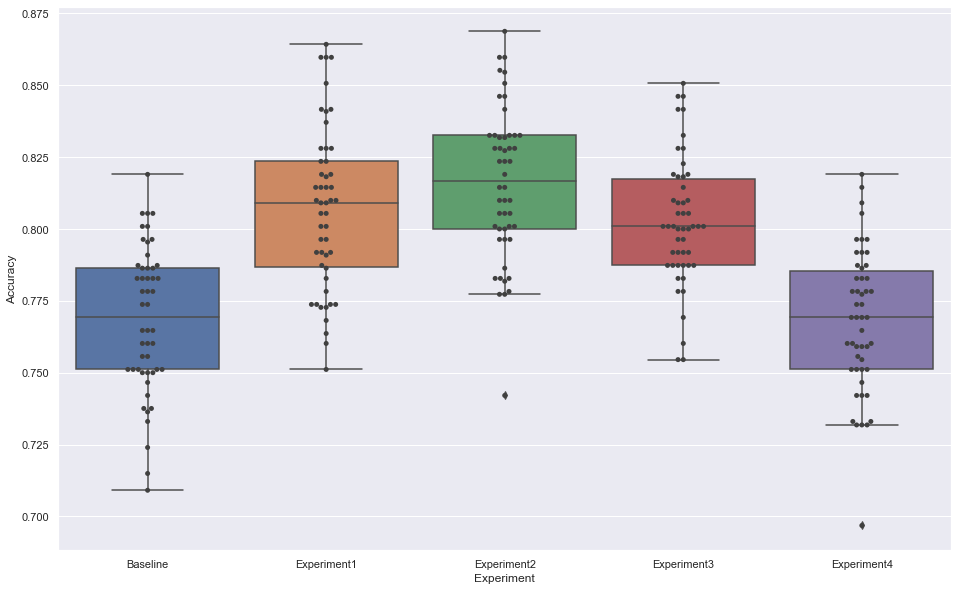

In [75]:
# Plot the distributions for each experiment in a boxplot form
plt.figure(figsize=(16, 10))
ax= sns.boxplot(x="Experiment", y="Accuracy", data=df_exp_results)
ax = sns.swarmplot(x="Experiment", y="Accuracy", data=df_exp_results, color=".25")

- **Baseline:** CountVectorizer (Word count) Multinomial Naive Bayes
- **Experiment1:** TfIdfCountVectorizer (tf binary) SVC
- **Experiment2:** Fixed window negation handling, TfIdfCountVectorizerf (tf binary) SVC
- **Experiment3:** Dependency parser negation handling, TfIdfCountVectorizer (tf binary) SVC
- **Experiment4:** Dense feature vector representation using doc2vect

In [76]:
# Repeated (10 times) 5-fold cross validation average accuracy of each experiments
df_exp_stats = df_exp_results.groupby('Experiment', as_index=False)['Accuracy'].mean()
df_exp_stats['Std'] = df_exp_results.groupby('Experiment', as_index=False)['Accuracy'].std()['Accuracy']
df_exp_stats['Median'] = df_exp_results.groupby('Experiment', as_index=False)['Accuracy'].median()['Accuracy']
df_exp_stats

,Experiment,Accuracy,Std,Median
0,Baseline,0.768384,0.025329,0.769231
1,Experiment1,0.806781,0.028382,0.809091
2,Experiment2,0.815934,0.026385,0.816742
3,Experiment3,0.802623,0.022409,0.800905
4,Experiment4,0.768109,0.024790,0.769231


The box plot above clearly shows the performances of each approach (experiment).
It is clear that as expected negation handling is a good strategy to improve the classifier performances. In fact Experiment2 ( which employes fix window nagation handling) has a slight advantage over Experiment1 which uses the same exact feature extraction strategy and calssifier but does not use nagation handling.  
Another interesting result is that classification using a dense feature vector by mean of word embedding although has outperformed the baseline case, it has scored the lowest amongst the 4 attempts to beat the initial classification performances. This might be due to the fact the word2Doc model was trained only on the the given train data. Although not guaranteed, using pre-trained models on bigger corpus might result in better final accuracy.



## Test Best Model on the test Data

Now that we have an overview on how each model performs, I can test the best performing model (**Experiment2 model**) on the test data and compare it to the baseline case

Accuracy improved Model = 0.8309352517985612. 
Accuracy baseline Model = 0.8093525179856115. 
F1 score  improved Model = 0.8290909090909091
F1 score baseline Model = 0.8100358422939068
[[117  22]
 [ 25 114]]


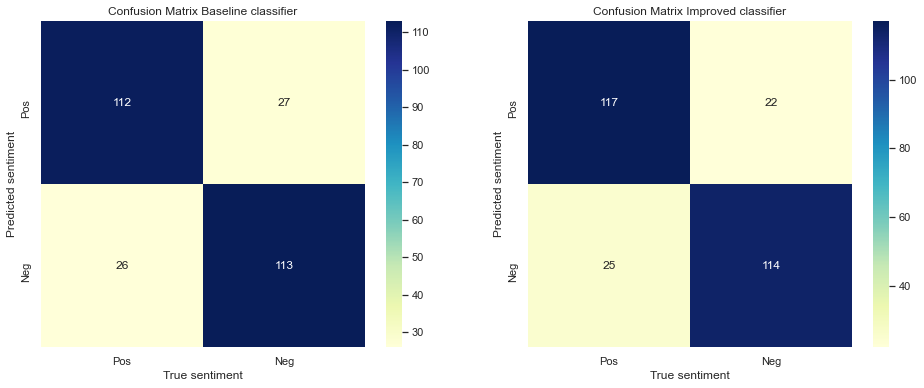

In [77]:
test =  True
if test:
    Y_test_int = sentiment_to_int(Y_test)
    X_test_processed_exp2 = processing_pipe_neg.transform(X_test)
    X_test_processed_baseline = processing_pipe.transform(X_test)
    Y_test_pred_exp2 = best_model_exp2.predict(X_test_processed_exp2)
    Y_test_pred_baseline = best_model_baseline.predict(X_test_processed_baseline)
    cnf_matrix_exp2 = confusion_matrix(Y_test_int, Y_test_pred_exp2)
    cnf_matrix_baseline = confusion_matrix(Y_test_int, Y_test_pred_baseline)
    avg_acc_exp2 = accuracy_score(Y_test_int, Y_test_pred_exp2)
    avg_acc_baseline = accuracy_score(Y_test_int, Y_test_pred_baseline)
    f1_exp2 = f1_score(Y_test_int, Y_test_pred_exp2)
    f1_baseline = f1_score(Y_test_int, Y_test_pred_baseline)
    print(f"Accuracy improved Model = {avg_acc_exp2}. ")
    print(f"Accuracy baseline Model = {avg_acc_baseline}. ")
    
    print(f"F1 score  improved Model = {f1_exp2}")
    print(f"F1 score baseline Model = {f1_baseline}")
    print(cnf_matrix_exp2)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,6))
    sns.heatmap(cnf_matrix_baseline,ax=ax1, annot=True, fmt="d",xticklabels=["Pos","Neg"],yticklabels=["Pos","Neg"],cmap="YlGnBu");
    sns.heatmap(cnf_matrix_exp2,ax=ax2, annot=True, fmt="d",xticklabels=["Pos","Neg"],yticklabels=["Pos","Neg"],cmap="YlGnBu")
    ax1.set_title('Confusion Matrix Baseline classifier');
    ax1.set_xlabel('True sentiment')
    ax1.set_ylabel('Predicted sentiment')
    ax2.set_title('Confusion Matrix Improved classifier');
    ax2.set_xlabel('True sentiment')
    ax2.set_ylabel('Predicted sentiment')
   

    

The two confusion matrices above compare the final performances of the improved model (Experiment2) with respect the baseline case. We can see that true positive have increased from 112 to 117 with the equivalent reduction fo false positive (27 to 22). A slight improvement was also recorded amongst the classification of negative reviews, where true negative went from 113 to 114 and false negative went from 26 to 25.
Both average accuracy and F1 score have increased.